# Data Mining: Slump

Name: Cyprien Calmels  
Python version: 3.8.12  
Jupyter Notebook version: 6.1.4  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from pandas.plotting import scatter_matrix
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

In [2]:
df = pd.read_csv('slump_test.data')

Concrete is made with the association of 7 or less components. We already know that water has an influence on the slump of the concrete. The goal of this study is to find if there is other relation between slump and concrete's components.

#  1-Characteristics of the data set

In [3]:
df.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [4]:
df.drop(['No'], axis = 1, inplace=True)  # I delete the first column which contains just the number of each concrete, which is useless.

In [5]:
print('There are',len(df),'datapoints and',len(df.columns),'variables.')

There are 103 datapoints and 10 variables.


Among this 10 variables, 7 are input parameters, consisting in concrete's components: Cement, Slag, Fly ash, Water, Superplastisizer, Coarse aggregate and Fine aggregate.  
The 3 variables left are the ouput parameters. They are measurements executed on concrete: Slump, Flow and Compressive strength after 28 days.

In [6]:
df.describe()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.00000,103.000000
mean,229.894175,77.973786,149.014563,197.167961,8.539806,883.978641,739.604854,18.048544,49.61068,36.039417
std,78.877230,60.461363,85.418080,20.208158,2.807530,88.391393,63.342117,8.750844,17.56861,7.838232
min,137.000000,0.000000,0.000000,160.000000,4.400000,708.000000,640.600000,0.000000,20.00000,17.190000
25%,152.000000,0.050000,115.500000,180.000000,6.000000,819.500000,684.500000,14.500000,38.50000,30.900000
50%,248.000000,100.000000,164.000000,196.000000,8.000000,879.000000,742.700000,21.500000,54.00000,35.520000
75%,303.900000,125.000000,235.950000,209.500000,10.000000,952.800000,788.000000,24.000000,63.75000,41.205000
max,374.000000,193.000000,260.000000,240.000000,19.000000,1049.900000,902.000000,29.000000,78.00000,58.530000


Above can be found all the typical statistic values for each column of the data set.

In [7]:
cement=df['Cement'].values
slag=df['Slag'].values
flyash=df['Fly ash'].values
water=df['Water'].values
sp=df['SP'].values
coarse=df['Coarse Aggr.'].values
fine=df['Fine Aggr.'].values
slump=df['SLUMP(cm)'].values
flow=df['FLOW(cm)'].values
strength=df['Compressive Strength (28-day)(Mpa)'].values

#Just be conveniance I create a list for each column of the data set, with a less complex name than at the origin.

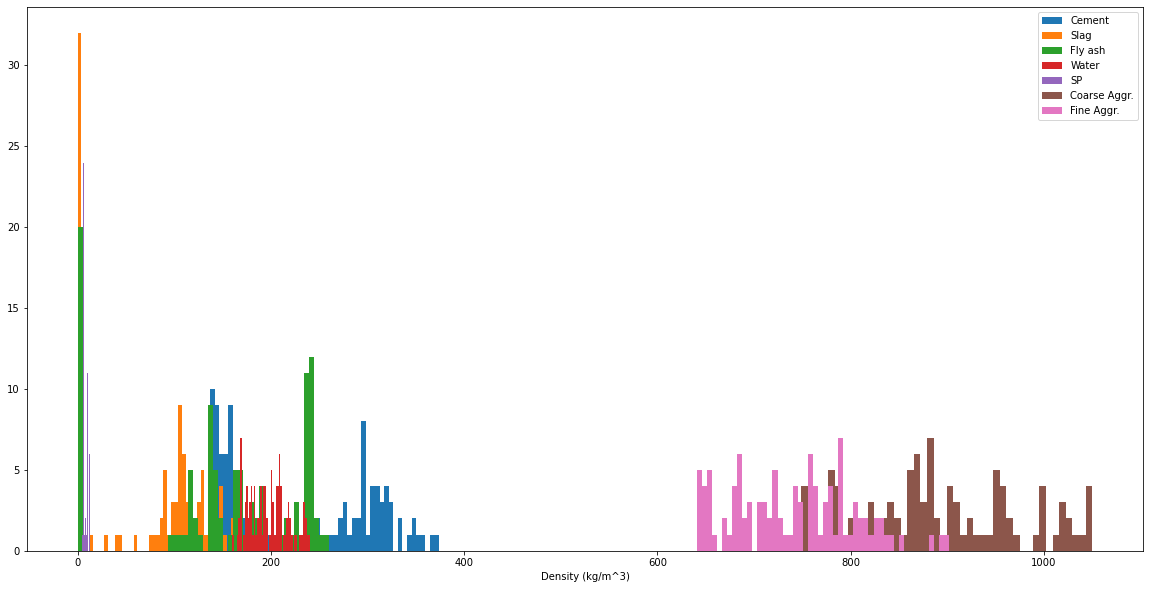

In [8]:
fig = plt.figure(figsize=(20,10))
plt.xlabel('Density (kg/m^3)')
for i in df.columns[0:7]:
    
    plt.hist(df[i].values, bins=50, label=i)
    plt.legend()

In order to see better the repartition of each component used to make concrete, their statistical distribution has been shown on the same histogram. 
The first visible interpretation is the huge preponderance of both coarse and fine aggregate in the concrete. Then comes cement and water, in some case fly ash. Slag is usually less used than this 3. Finally, superplasticizer is the least weighted component, by far.

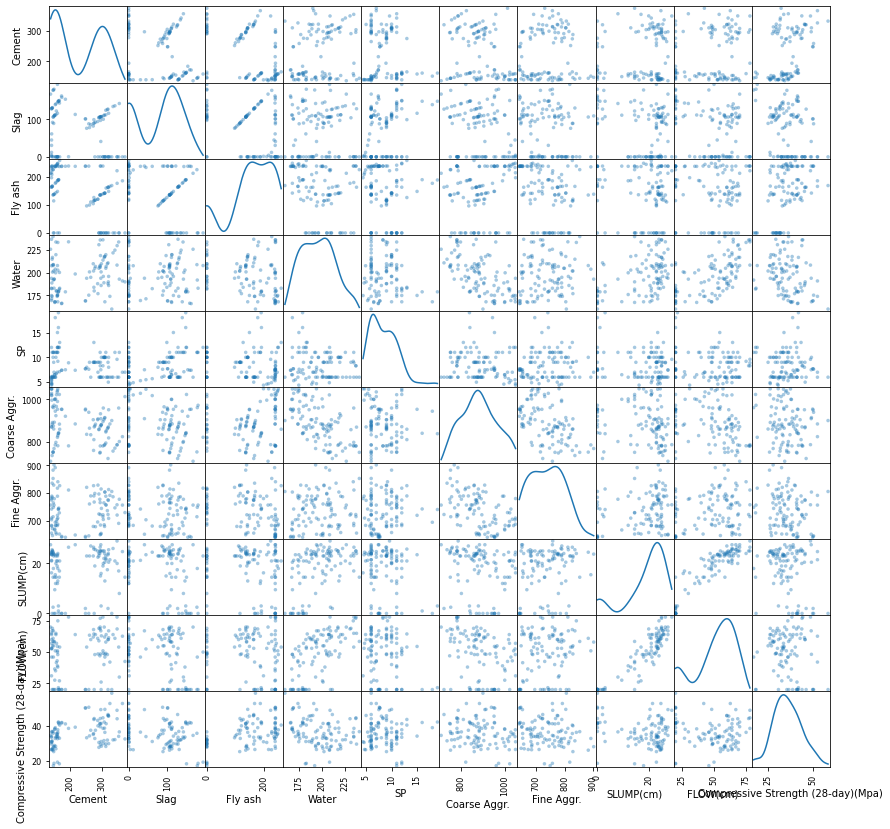

In [9]:
scatter_matrix(df[:2000], figsize=(14, 14), alpha=0.4, s=50, diagonal='kde');
# to see if there is any correlation between an input and an output variable

A scatter plot is a good way to see easily if there is any correlation between 2 columns of a data set. Here except for slump and flow, nothing seems obvious.

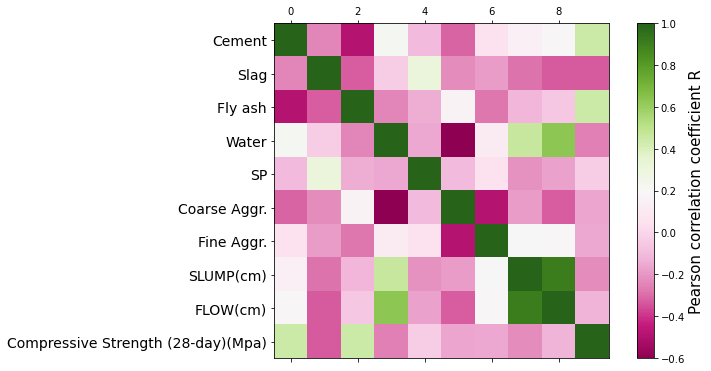

In [10]:
f=plt.figure(figsize=(10,6))
plt.matshow(df.corr(), fignum=f.number, cmap='PiYG')
cb=plt.colorbar()
cb.set_label(r"Pearson correlation coefficient R", size = 15)

#plt.xticks(np.linspace(0,9,10), df.columns, rotation=90, fontsize=14)
plt.yticks(np.linspace(0,9,10), df.columns, fontsize=14)
plt.show()

To be more precise on what we saw just above, we can display the pearson correlation coefficient for each couple of argument.
Indeed, Slump and Flow are very correlated. We see as well that Coarse aggregate and water are very anti-correlated.  
As we are interested in the influence of components to slump, we know that we will need to go further if we hope to find interesting relationship or patterns and that a simple correlation coefficient won't be enough.

As each component is given by its weigth in kilograms used for 1 cubic meter of concrete, if we add them all for each concrete we will then obtain the density of each concrete. It can be interested to see if this new input variable is related to slump.

In [11]:
density=[]
for j in range(len(df)):
    somme=[]
    for i in df.columns[0:7]:
        liste=df[i].values
        valeur=liste[j]
        somme.append(valeur)
    density.append(np.sum(somme))
    
print('mean=',np.mean(density),'\n','min=',min(density),'\n','max=',max(density),'\n','std=',np.std(density))

mean= 2286.1737864077672 
 min= 2200.0 
 max= 2374.0 
 std= 40.02122243118539


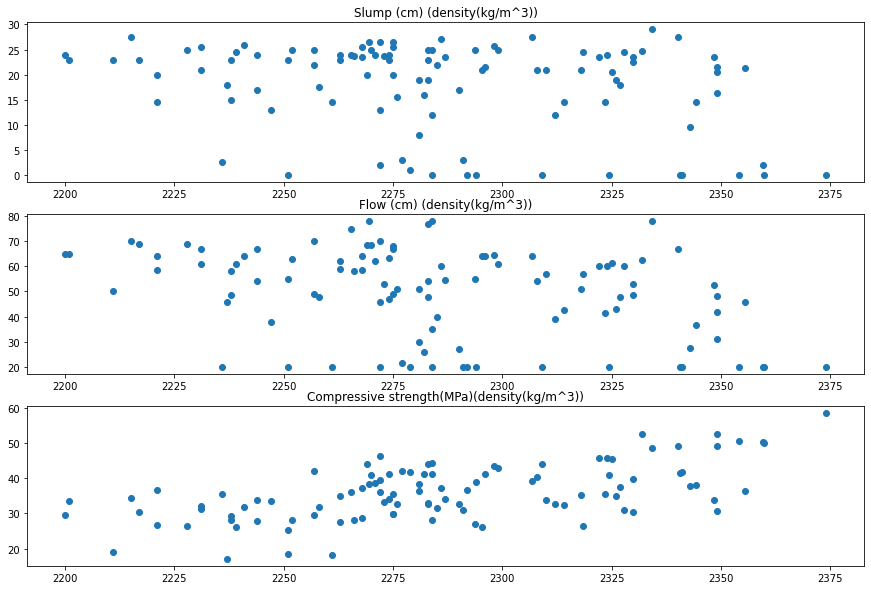

In [12]:
fig = plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(density, slump, 'o')
plt.title('Slump (cm) (density(kg/m^3))')

plt.subplot(312)
plt.plot(density, flow, 'o')
plt.title('Flow (cm) (density(kg/m^3))')

plt.subplot(313)
plt.plot(density, strength, 'o')
plt.title('Compressive strength(MPa)(density(kg/m^3))');

The compressive strength seems to be quite correlated with the density of the concrete, while for slump and flow it's really less obvious. We won't be able to use this to have strong conclusion.

As the study covers the influence of components on slump, and that this last is correlated with flow, I choose to see the composition of concretes with the maximal or minimal flow.

In [13]:
result = np.where(flow == np.amax(flow))
print(result)
result = np.where(flow == np.amin(flow))
print(result)

(array([ 87,  92, 102]),)
(array([  1,   2,   6,  22,  24,  37,  40,  44,  48,  68,  70,  93,  94,
        95,  98,  99, 100]),)


Density 1 =  2334.3
Density 2 =  2283.8999999999996
Density 3 =  2269.6


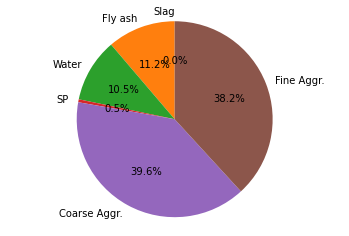

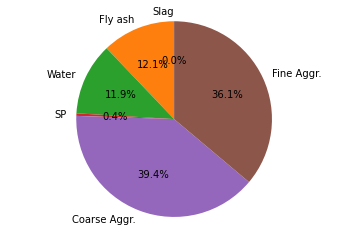

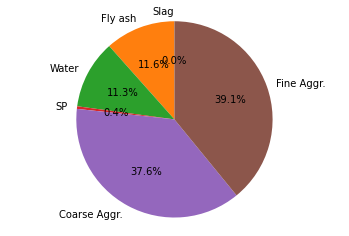

In [14]:
x = [(df[i].values[102]/density[102])*100 for i in df.columns[1:7]]
x2 = [(df[i].values[92]/density[92])*100 for i in df.columns[1:7]]
x3 = [(df[i].values[87]/density[87])*100 for i in df.columns[1:7]]
label = df.columns[1:7]

print('Density 1 = ', density[102])
fig1, ax1 = plt.subplots()
ax1.pie(x, labels=label, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal') 

print('Density 2 = ', density[92])
fig2, ax2 = plt.subplots()
ax2.pie(x2, labels=label, autopct='%1.1f%%', shadow=False, startangle=90)
ax2.axis('equal') 

print('Density 3 = ', density[87])
fig3, ax3 = plt.subplots()
ax3.pie(x3, labels=label, autopct='%1.1f%%', shadow=False, startangle=90)
ax3.axis('equal') 

plt.show();

An interesting thing maybe is that for the 3 concrete showing the maximal value of flow, there is absolutely no slag. Even if their densities vary a lot, each composition seems to have quite the same proportion.
But this is just a parenthesis, we can't look at specific case to find general conclusion on a much larger sample.

# 2- Attribute selection/extraction

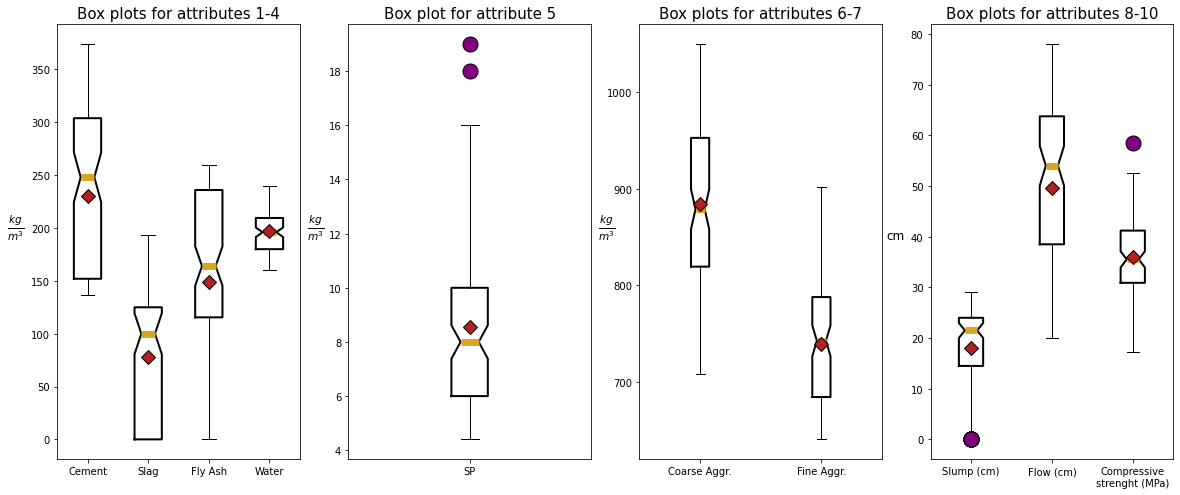

In [15]:
data1 = [cement, slag, flyash, water]
data2 = sp
data3 = [coarse, fine]
data4 = [slump, flow, strength]

boxprops = dict(linestyle='-', linewidth=2, color='black')
flierprops = dict(marker='o',markerfacecolor='purple',markersize=15,markeredgecolor='black')
medianprops = dict(linestyle='--', linewidth=7, color='goldenrod')
meanpointprops = dict(marker='D',markeredgecolor='black',markersize=10,markerfacecolor='firebrick')

fig = plt.figure(figsize=(20,8))
plt.subplot(141)
label1= ["Cement","Slag", "Fly Ash", "Water"]
plt.boxplot(data1,notch=True,vert=True,showmeans=True,boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,meanprops=meanpointprops,labels=label1)
plt.title("Box plots for attributes 1-4",fontsize=15)
plt.ylabel(r"$\frac{kg}{m^3}$",rotation = 'horizontal',labelpad=15,fontsize=15)
plt.subplot(142)
label2 =  ["SP"]
plt.boxplot(data2,notch=True,vert=True,showmeans=True,boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,meanprops=meanpointprops,labels=label2)
plt.title("Box plot for attribute 5",fontsize=15)
plt.ylabel(r"$\frac{kg}{m^3}$",rotation = 'horizontal',labelpad=13,fontsize=15)
plt.subplot(143)
label3 = ["Coarse Aggr.","Fine Aggr."]
plt.boxplot(data3,notch=True,vert=True,showmeans=True,boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,meanprops=meanpointprops,labels=label3)
plt.title("Box plots for attributes 6-7",fontsize=15)
plt.ylabel(r"$\frac{kg}{m^3}$",rotation = 'horizontal',labelpad=0,fontsize=15)
plt.subplot(144)
label4 = ["Slump (cm)","Flow (cm)","Compressive\nstrenght (MPa)"]
plt.boxplot(data4,notch=True,vert=True,showmeans=True,boxprops=boxprops,flierprops=flierprops,medianprops=medianprops,meanprops=meanpointprops,labels=label4)
plt.title("Box plots for attributes 8-10",fontsize=15)
plt.ylabel(r"cm",rotation = 'horizontal',labelpad=15,fontsize=12);

We can look with boxplot to see if we have some outliers. There are some, but not a single one is an outlier for every argument. We can see this quickly because just 3 arguments have outliers. So we can't delete them or replace them by mean or median values.  
An intriguing fact concerning slump is that all its outliers are at 0 cm of slump. This is physically impossible so we could suppose that the device used to measure slump hasn't a resolution good enough. We won't change anything in the data set but it is a possible explanation for this huge amount of outliers in that column.

# 3-Clustering

We will now work on making clusters. So it's necessary to standardize the dataframe, because if not, the distance between points won't be relevant as each axis has a different scale. 

In [16]:
df[df.columns] = StandardScaler().fit_transform(df)
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,0.549165,0.066917,-0.517804,0.638098,0.164716,0.227616,-0.945600,0.568593,0.708645,-0.134539
1,-0.852227,1.180482,0.493932,-0.853710,1.238496,-0.465871,0.101456,-2.072577,-1.693673,0.653913
2,-0.864967,1.163861,0.493932,-0.903437,2.670203,-0.499977,0.053862,-1.957744,-1.693673,0.739810
3,-0.864967,1.163861,0.482168,-0.903437,3.743983,-0.522715,0.022133,-1.728077,-1.607876,0.774425
4,-0.966886,0.565528,-0.058993,1.135368,0.522643,0.443620,-1.294619,0.224093,0.823041,-1.181963


In order to be able to visualize our clusters on a 2D or 3D plot, we need to do dimensionality reduction, because for the moment 10 dimensions are in our data set.
We will do it with a PCA. But we face an issue which is that by decreasing the number of dimension we will lose information. We don't want to lose the final goal of clustering which is doing data mining. If too much information disappears in the process, doing clusters will be useless as we won't analyse something close to our original data.  
Furthermore, as we are interested by finding structures between the 7 input arguments, we will only keep them before the PCA. And then we will see if our clusters have some relations with slump.

In [17]:
INPUT = df[df.columns[0:7]]
INPUT.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.
0,0.549165,0.066917,-0.517804,0.638098,0.164716,0.227616,-0.945600
1,-0.852227,1.180482,0.493932,-0.853710,1.238496,-0.465871,0.101456
2,-0.864967,1.163861,0.493932,-0.903437,2.670203,-0.499977,0.053862
3,-0.864967,1.163861,0.482168,-0.903437,3.743983,-0.522715,0.022133
4,-0.966886,0.565528,-0.058993,1.135368,0.522643,0.443620,-1.294619


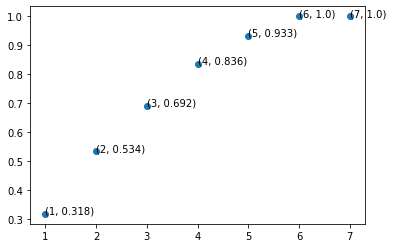

In [18]:
y=[]
x=np.arange(1,8,1)
for i in x:
    pca = PCA(n_components=i)
    res = pca.fit_transform(INPUT)
    y.append(np.round(np.sum(pca.explained_variance_ratio_), 3))
plt.plot(x,y, 'o')

for i_x, i_y in zip(x, y):
    plt.text(i_x, i_y, '({}, {})'.format(i_x, i_y))
    
plt.show();

Keeping more than 80% of the information is something fine when we do a PCA. If we want to reach this goal we need to keep at least 4 components (here with 4 we have 83.36%). 
Unfortunately we didn't learn how to do a 4D plot, so we will just visualize 3 of our dimensions. But the distance calculated between points to make clusters will be well calculated with this 4 dimensions (euclidian distance has this benefit).

In [19]:
pca_4 = PCA(n_components=4)
res = pca_4.fit_transform(INPUT)

print(np.sum(pca_4.explained_variance_ratio_))
x = [res[i][0] for i in range(len(res))]
y = [res[i][1] for i in range(len(res))]
z = [res[i][2] for i in range(len(res))]
k= [res[i][3] for i in range(len(res))]


X = [[x[i],y[i], z[i], k[i]] for i in range(len(res))]

print('Cumulative variance explained by 4 principal components: {:.2%}'.format(np.sum(pca_4.explained_variance_ratio_)))


0.8361098405885852
Cumulative variance explained by 4 principal components: 83.61%


We will use different clustering algorithms, and compare them. We choose to make clusters with DBSCAN, OPTICS, Spectral and KMeans.  
DBSCAN and OPTICS work quite similarly, by taking into account densities of points (OPTICS is reputated to do this better). So they need to know 2 things :  
- the Epsilon, which is the minimal distance we want between points belonging to the same cluster;  
- the minimum number of points into clusters.

Spectral and KMeans work as well similarly, they just need to know how much clusters we want and then the cut the space of our data set by choosing random points as centroids of clusters, until they reach the optimal configuration.

We expect different results from this 4 clustering methods because the main difference between the 2 first and 2 last is that in the first case, some points may not belong to a cluster, not in the second case. This will inevitably have consequences with the computation of the different scores that will tell us if our clustering is good or not.

In order to find the optimal values for eps and min_samples or n_clusters, we will loop over them to test each configuration. To know which is the best, we use 3 different scoring indices : Davies Bouldin, Silhouette index and Calinski Harabasz. 
We will find for which values in argument we have the optimal value of each of this 3 scores. We must find 3 configurations, and then see for each of them the value of our 3 scores. This will help to find the "perfect" choice of argument because we could have a convergence of 2 scoring methods on the same configuration.

In order to well understand what our scores will mean, we should just describe them before using them:  
### Davies Bouldin:  
It varies between 0 (best classification) and +infinity (worst classification). It is the average of the maximal ratio between a point to its centroid and 2 centroids.  
### Silhouette Index:
It varies between -1 and +1.  
S > 0.70 Strong structures have been found   
0.5 < S < 0.70 reasonable structures have been found  
0.25 < S < 0.5 Weak structures have been found  
0 < S < 0.25 No substantial structure found  
S < 0 This clustering is most likely garbage  
### Calinski Harabasz:
It varies between 0 (worst classification) and +infinity (best classification). It's the ratio between the inter-group variance and the intra-group variance. It depends a lot of the size of our sample. For 2 identical clustering quality, it growns linearly with N.

In [20]:
#DBSCAN
DB=[]
SI=[]
CH=[]
n = np.arange(0.5,3,0.1)
m=np.arange(3,15,1)
eps=[]
samples=[]
for i in n:
    for j in m:
        clustering = DBSCAN(eps=i, min_samples=j).fit(X)
        labels = list(clustering.labels_)
        if len(set(labels)) != 1:
            DB.append(np.round(davies_bouldin_score(X,clustering.labels_),2))
            SI.append(np.round(silhouette_score(X,clustering.labels_),2))
            CH.append(np.round(calinski_harabasz_score(X,clustering.labels_),2))
            eps.append(i)
            samples.append(j)
            
index1=DB.index(min(DB))
index2=SI.index(max(SI))
index3=CH.index(max(CH))

print('DBSCAN best configuration')
print('eps =',eps[index1], 'min_samples =', samples[index1],'\n','eps =', eps[index2],'min_samples =', samples[index2],'\n','eps =', eps[index3],'min_samples =', samples[index3])
print('DB1 =',DB[index1],'SI1 =', SI[index1],'CH1 =',CH[index1],'\n','DB2 =',DB[index2],'SI2 =', SI[index2], 'CH2 =',CH[index2],'\n','DB3 =',DB[index3],'SI3 =', SI[index3],'CH3 =', CH[index3])

#OPTICS
DB=[]
SI=[]
CH=[]
eps=[]
samples=[]
for i in n:
    for j in m:
        clustering = OPTICS(eps=i, min_samples=j).fit(X)
        labels = list(clustering.labels_)
        if len(set(labels)) != 1:
            DB.append(np.round(davies_bouldin_score(X,clustering.labels_),2))
            SI.append(np.round(silhouette_score(X,clustering.labels_),2))
            CH.append(np.round(calinski_harabasz_score(X,clustering.labels_),2))
            eps.append(i)
            samples.append(j)
            
index1=DB.index(min(DB))
index2=SI.index(max(SI))
index3=CH.index(max(CH))

print('\n','     ')
print('OPTICS best configuration')
print('eps =',eps[index1], 'min_samples =', samples[index1],'\n','eps =', eps[index2],'min_samples =', samples[index2],'\n','eps =', eps[index3],'min_samples =', samples[index3])
print('DB1 =',DB[index1],'SI1 =', SI[index1],'CH1 =',CH[index1],'\n','DB2 =',DB[index2],'SI2 =', SI[index2], 'CH2 =',CH[index2],'\n','DB3 =',DB[index3],'SI3 =', SI[index3],'CH3 =', CH[index3])


DBSCAN best configuration
eps = 2.1999999999999997 min_samples = 14 
 eps = 1.4999999999999998 min_samples = 9 
 eps = 1.4999999999999998 min_samples = 10
DB1 = 0.69 SI1 = 0.16 CH1 = 1.93 
 DB2 = 1.93 SI2 = 0.26 CH2 = 28.35 
 DB3 = 1.93 SI3 = 0.25 CH3 = 28.45

      
OPTICS best configuration
eps = 0.5 min_samples = 13 
 eps = 0.5 min_samples = 9 
 eps = 0.5 min_samples = 9
DB1 = 1.18 SI1 = 0.23 CH1 = 28.46 
 DB2 = 1.24 SI2 = 0.26 CH2 = 35.52 
 DB3 = 1.24 SI3 = 0.26 CH3 = 35.52


For DBSCAN, our best configuration could be eps=1.5 and min_samples=9 because it's for this case that we have the best silhouette index and Calinski Harabasz (both are roughly equal with the min_sample=10 case). We see that Davies Bouldin and Calinski Harabasz are in complete disagreement. It's probably due to the different way of computing.  
For OPTICS, the eps is always the same, and there is an agreement between SI and CH for a min_samples of 9. So we will take these values. 

In [21]:
#SPECTRAL
DB=[]
SI=[]
CH=[]
n=np.arange(3,15,1)
n_clusters=[]
for i in n:
    clustering = SpectralClustering(n_clusters=i).fit(X)
    labels = list(clustering.labels_)
    if len(set(labels)) != 1:
        DB.append(np.round(davies_bouldin_score(X,clustering.labels_),2))
        SI.append(np.round(silhouette_score(X,clustering.labels_),2))
        CH.append(np.round(calinski_harabasz_score(X,clustering.labels_),2))
        n_clusters.append(i)
            
index1=DB.index(min(DB))
index2=SI.index(max(SI))
index3=CH.index(max(CH))

print('SPECTRAL best configuration')
print('n clusters =',n_clusters[index1], '\n','n clusters =', n_clusters[index2],'\n', 'n_clusters =', n_clusters[index3])
print('DB1 =',DB[index1],'SI1 =', SI[index1],'CH1 =',CH[index1],'\n','DB2 =',DB[index2],'SI2 =', SI[index2], 'CH2 =',CH[index2],'\n','DB3 =',DB[index3],'SI3 =', SI[index3],'CH3 =', CH[index3])

#KMEANS
DB=[]
SI=[]
CH=[]
n_clusters=[]
for i in n:
    clustering = KMeans(n_clusters=i).fit(X)
    labels = list(clustering.labels_)
    if len(set(labels)) != 1:
        DB.append(np.round(davies_bouldin_score(X,clustering.labels_),2))
        SI.append(np.round(silhouette_score(X,clustering.labels_),2))
        CH.append(np.round(calinski_harabasz_score(X,clustering.labels_),2))
        n_clusters.append(i)
            
index1=DB.index(min(DB))
index2=SI.index(max(SI))
index3=CH.index(max(CH))

print('\n','     ')
print('KMEANS best configuration')
print('n clusters =',n_clusters[index1],'\n', 'n clusters =', n_clusters[index2], '\n','n_clusters =', n_clusters[index3])
print('DB1 =',DB[index1],'SI1 =', SI[index1],'CH1 =',CH[index1],'\n','DB2 =',DB[index2],'SI2 =', SI[index2], 'CH2 =',CH[index2],'\n','DB3 =',DB[index3],'SI3 =', SI[index3],'CH3 =', CH[index3])


SPECTRAL best configuration
n clusters = 11 
 n clusters = 14 
 n_clusters = 3
DB1 = 0.93 SI1 = 0.26 CH1 = 26.81 
 DB2 = 0.98 SI2 = 0.29 CH2 = 28.96 
 DB3 = 1.11 SI3 = 0.28 CH3 = 33.84

      
KMEANS best configuration
n clusters = 11 
 n clusters = 5 
 n_clusters = 6
DB1 = 0.98 SI1 = 0.3 CH1 = 36.31 
 DB2 = 1.19 SI2 = 0.31 CH2 = 38.24 
 DB3 = 1.08 SI3 = 0.31 CH3 = 39.67


For SPECTRAL, our best configuration seems to be with 3 clusters. Again DB and CH are in a little disagreement. It's the silhouette index that help us to take a decision. It's our only normalized score so it's giving us an absolute indication. While the 2 others are more useful to compare 2 techniques.    
For KMeans, with 6 clusters we reach approximately the best for all our 3 scoring methods. The usual DB/CH disagreement is present but again the silhouette idex helps us. But even for it we have very close results. In fact, KMeans seems to give better results than other clustering algorithms anyway. 

We will know try our best configuration for each clustering methods and visualize 3D clusters (the 4th dimension won't be visible). We will look as well at the slump as a function of the 3D PCA and see if by eyes there are some patterns. 

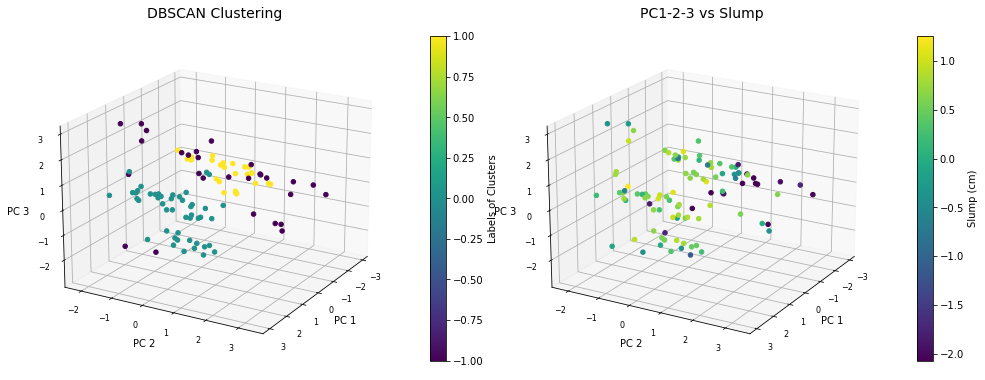

In [22]:
# clustering with DBSCAN

clustering = DBSCAN(eps=1.5, min_samples=9).fit(X)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(121,projection='3d')
p = ax.scatter(x,y,z,c=clustering.labels_,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('DBSCAN Clustering',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Labels of Clusters')

ax = fig.add_subplot(122,projection='3d')
p = ax.scatter(x,y,z,c=slump,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('PC1-2-3 vs Slump',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Slump (cm)')

In [23]:
for j in range(2):
    result = np.where(clustering.labels_ == j-1)
    result2=list(result)
    test=[]
    for i in result2:
        test.append(slump[i])
    print(np.std(test))

1.1061166116845058
0.8020881044600796


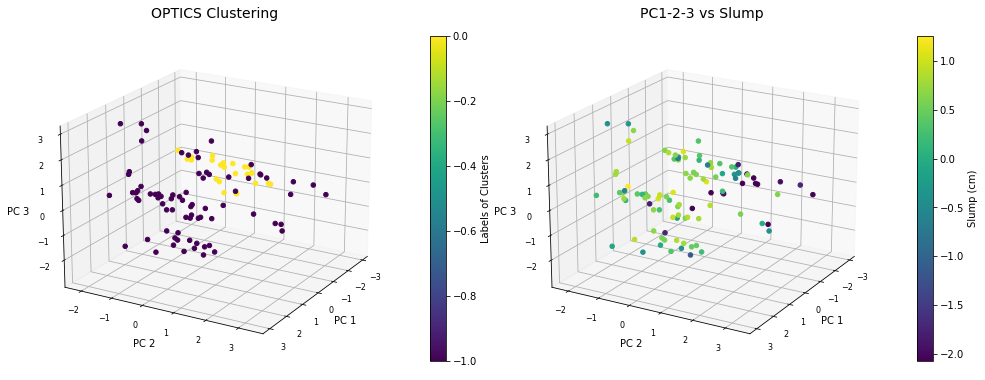

In [24]:
# clustering with OPTICS
clustering = OPTICS(eps=0.5, min_samples=9).fit(X)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(121,projection='3d')
p = ax.scatter(x,y,z,c=clustering.labels_,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('OPTICS Clustering',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Labels of Clusters')

ax = fig.add_subplot(122,projection='3d')
p = ax.scatter(x,y,z,c=slump,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('PC1-2-3 vs Slump',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Slump (cm)')

In [25]:
for j in range(1):
    result = np.where(clustering.labels_ == j-1)
    result2=list(result)
    test=[]
    for i in result2:
        test.append(slump[i])
    print(np.std(test))

0.9532806496684647


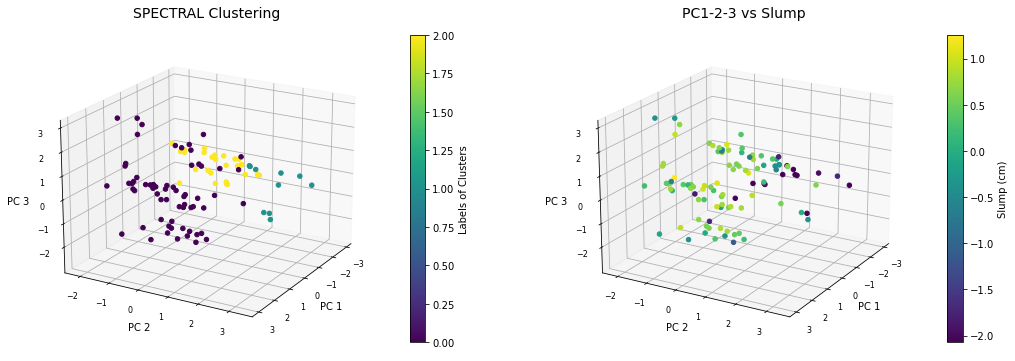

In [26]:
# clustering with SPECTRAL
clustering = SpectralClustering(n_clusters=3).fit(X)
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(121,projection='3d')
p = ax.scatter(x,y,z,c=clustering.labels_,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('SPECTRAL Clustering',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Labels of Clusters')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

ax = fig.add_subplot(122,projection='3d')
p = ax.scatter(x,y,z,c=slump,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('PC1-2-3 vs Slump',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Slump (cm)')

In [27]:
for j in range(3):
    result = np.where(clustering.labels_ == j-1)
    result2=list(result)
    test=[]
    for i in result2:
        test.append(slump[i])
    print(np.std(test))

nan
0.7833794665557732
1.1246392765474567


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


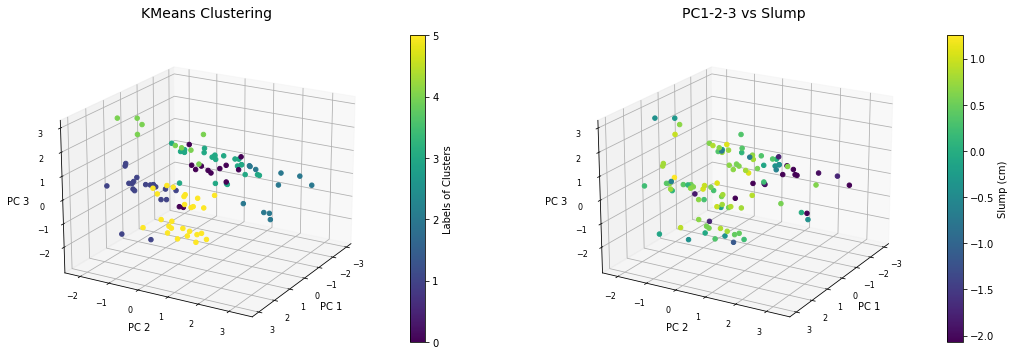

In [28]:
# clustering with KMEANS

clustering = KMeans(n_clusters=6).fit(X)
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(121,projection='3d')
p = ax.scatter(x,y,z,c=clustering.labels_,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('KMeans Clustering',fontsize=14)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.view_init(elev=20, azim=30)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Labels of Clusters')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

ax = fig.add_subplot(122,projection='3d')
p = ax.scatter(x,y,z,c=slump,alpha=1)
ax.set_xlabel('PC 1',fontsize=10)
ax.set_ylabel('PC 2',fontsize=10)
ax.set_zlabel('PC 3',fontsize=10)
ax.set_title('PC1-2-3 vs Slump',fontsize=14)
ax.view_init(elev=20, azim=30)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
fig.colorbar(p,ax=ax,fraction=0.04, pad=0.1,label='Slump (cm)')

In [29]:
for j in range(6):
    result = np.where(clustering.labels_ == j-1)
    result2=list(result)
    test=[]
    for i in result2:
        test.append(slump[i])
    print(np.std(test))

nan
0.7842299588423175
0.6994407775143249
1.175980918662479
1.0725986370214753
0.46299651294496136


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


For each algorithm, we printed the std of the slump in each clusters. As the data set is standardized, the std of slump is equal to 1 if we take into account the 103 data points.  
Here we note that in each case the std is close to 1, the best we have found is 0.68 for a cluster of KMeans. This is maybe a clue that our clustering isn't very efficient and that we won't find strong relation between components and slump. Otherwise std would be lower, meaning that each cluster owns a specific population defined by its slump.  
This could be seen as a way to mathematically translate the fact that visualy there is no obvious identification between clusters and slump (by looking at colors).

# Conclusion

According to the Sihlouette index and Calinski Harabasz, the best clustering method is KMeans (SI=0.32, CH=39.81). At least, they show their best score for this algorithms.  
Davies Bouldin has its best value for DBSCAN (0.69), but at the same time it's as well the worst for Calinski Harabasz (1.93). 

The way these scores are calculated may differ. But when we have such a divergence between 2 methods it is that the clustering is probably not optimal. This is why choosing different indices is important. We can compare them, something they all (or almost) agree and it gives a strong clue about the quality of the clustering.

However, according to the Sihlouette index, we have, the best, weak structures identified. Few reasons may be responsible of that. First our data set contains just 103 points. There may be some subject of study for which it is enough to have a strong interpretation, but we can suppose that in our case it is not.  
One of the first consequence we noted is the lack of correlation between columns. If instead of a hundred we had like 10,000 data points, this could have lead to stronger correlation or anti-correlation. The point of that is to easily see the influence of each component on the slump.  
Even if each component taking individually doesn't show a strong influence on slump, maybe that after clusterising the data we would have find a link between slump and the 7 components.  